# Sentiment Analysis

After thorough preprocessing and cleaning, our dataset is now primed for a detailed sentiment analysis. This analysis focuses on user comments extracted from the subreddit `r/ETFs`, specifically those that mention the Vanguard S&P 500 ETF, commonly referred to as `VOO`. 

In this section, we aim to assess the prevailing sentiments within the community discussions about VOO. Understanding these sentiments can provide insights into general investor attitudes and potential market trends related to this ETF. We'll employ various sentiment analysis techniques to quantify how positive, neutral, or negative each comment is.

This process not only helps in gauging the overall market sentiment towards VOO but also aids in predicting investor behavior and potential movements in ETF performance based on public perception.

---

## Import the datasets

In [36]:
import pandas as pd

df = pd.read_csv('../datasets/cleaned_cmts_voo.csv')
df.head()

,date,body
0,2024-03-27,Just buy VOO at this point
1,2024-03-27,Voo & schg have 53% overlap. Past results don’...
2,2024-03-27,Schd + Schg makes up the majority of voo. Just...
3,2024-03-27,13% overlap with VOO and less than 1% overlap ...
4,2024-03-28,"30% VOO, 30% QQQ, 10% VYM, 10% BND, 10% Mixed ..."


---

## Using Transformer Model in Sentiment Analysis

In this section, we leverage the powerful FinBERT model, a transformer-based model fine-tuned for financial sentiment analysis. Hosted on Hugging Face at [yiyanghkust/finbert-tone](https://huggingface.co/yiyanghkust/finbert-tone), FinBERT is an adaptation of the widely-acclaimed BERT architecture, tailored to understand the nuances of financial discourse.

### Example

We utilize the `pipeline` function from the `transformers` library to instantiate a sentiment analysis pipeline with the FinBERT model (`yiyanghkust/finbert-tone`). This model is adept at discerning sentiment in financial texts, categorizing them into distinct classes:

- **Positive**: Represented by label `2`.
- **Neutral**: Represented by label `1`.
- **Negative**: Represented by label `0`.

Each text is processed through the `classify_sentiment` function, which utilizes the FinBERT model to predict the sentiment label and a corresponding confidence score. The sentiment score provides a nuanced understanding of sentiment intensity

1. **Positive Sentence**: "Stock price will increase." - Expected to return a sentiment label indicating a positive sentiment.
2. **Neutral Sentence**: "VOO is Vanguard S&P 500 ETF." - Expected to be classified as neutral as it merely states a fact.
3. **Negative Sentence**: "Stock price will decrease." - Expected to express a negative sentiment.

Here's how we execute this analysis:

In [37]:
from transformers import pipeline

model_name = "yiyanghkust/finbert-tone"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

# Function to classify sentiment of a single text
def classify_sentiment(text):
    result = sentiment_pipeline(text)[0]
    # Update the sentiment label mapping based on the actual output of your model
    sentiment_labels = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
    label = sentiment_labels.get(result['label'], -1)  # Default to -1 if label not found
    score = result['score']
    return label, score

pos_text = "Stock price will increase."
neu_text = "VOO is Vanguard S&P 500 ETF."
neg_text = "Stock price will decrease."

pos_label, pos_score = classify_sentiment(pos_text)
neu_label, neu_score = classify_sentiment(neu_text)
neg_label, neg_score = classify_sentiment(neg_text)

header = f"{'Sentence Type':<20} {'Sentiment Label':<20} {'SentimentScore':<10}"
print(header)
print("-" * len(header))  # Prints a separator line
print(f"{'Positive sentence:':<20} {pos_label:<20} {pos_score:<10f}")
print(f"{'Neutral sentence:':<20} {neu_label:<20} {neu_score:<10f}")
print(f"{'Negative sentence:':<20} {neg_label:<20} {neg_score:<10f}")

Sentence Type        Sentiment Label      SentimentScore
--------------------------------------------------------
Positive sentence:   2                    0.956162  
Neutral sentence:    1                    0.999998  
Negative sentence:   0                    0.969693  


### Classifying Sentiments in Reddit Comments

In this section, we apply the sentiment analysis pipeline using the FinBERT model to classify the sentiment of comments related to the ETF `VOO` from Reddit. The FinBERT model, being specialized for financial contexts, provides us with insights into the public sentiment expressed in these comments.

#### Implementation

Given the limitations of the model to handle lengthy texts, we truncate comments to the first 512 characters. This ensures that the model operates within its design specifications without compromising the input's integrity.

Here's how we execute the sentiment classification on our dataset:

In [38]:
from transformers import pipeline

model_name = "yiyanghkust/finbert-tone"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

In [39]:
# Function to classify sentiment of a single text
def classify_sentiment(text):
    result = sentiment_pipeline(text)[0]
    # Update the sentiment label mapping based on the actual output of your model
    sentiment_labels = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
    label = sentiment_labels.get(result['label'], -1)  # Default to -1 if label not found
    score = result['score']
    return label, score

# Apply the sentiment analysis to each comment
sentiment_results = df['body'].apply(lambda x: classify_sentiment(x[:512]))  # Limiting character count to 512

# Create new columns for sentiment label and sentiment score
df['sentiment_label'], df['sentiment_score'] = zip(*sentiment_results)

# Check the DataFrame
df.head()

,date,body,sentiment_label,sentiment_score
0,2024-03-27,Just buy VOO at this point,1,0.996938
1,2024-03-27,Voo & schg have 53% overlap. Past results don’...,2,0.976062
2,2024-03-27,Schd + Schg makes up the majority of voo. Just...,1,0.999913
3,2024-03-27,13% overlap with VOO and less than 1% overlap ...,1,0.999995
4,2024-03-28,"30% VOO, 30% QQQ, 10% VYM, 10% BND, 10% Mixed ...",1,1.000000


### Checking for Missing Values

Before proceeding with further data analysis or visualization, it's crucial to ensure that the dataset is complete and does not contain any missing values that could skew the results or lead to errors during computational processes.

In [40]:
df.isnull().sum()

date               0
body               0
sentiment_label    0
sentiment_score    0
dtype: int64

---

## Visualizing the Data

### 1. Time Series of Sentiment Counts
- **What it shows**: This bar chart displays the comparison of the count of positive, neutral, and negative comments over time.
- **Interpretation**: 
  - The height of the bars represents the count of sentiments (positive, neutral, or negative) on each date.
  - Higher bars for a sentiment type on a specific date indicate more comments with that sentiment.
  - Comparing the heights of the bars for each sentiment type on each date provides a visual representation of the predominant sentiment on that day.

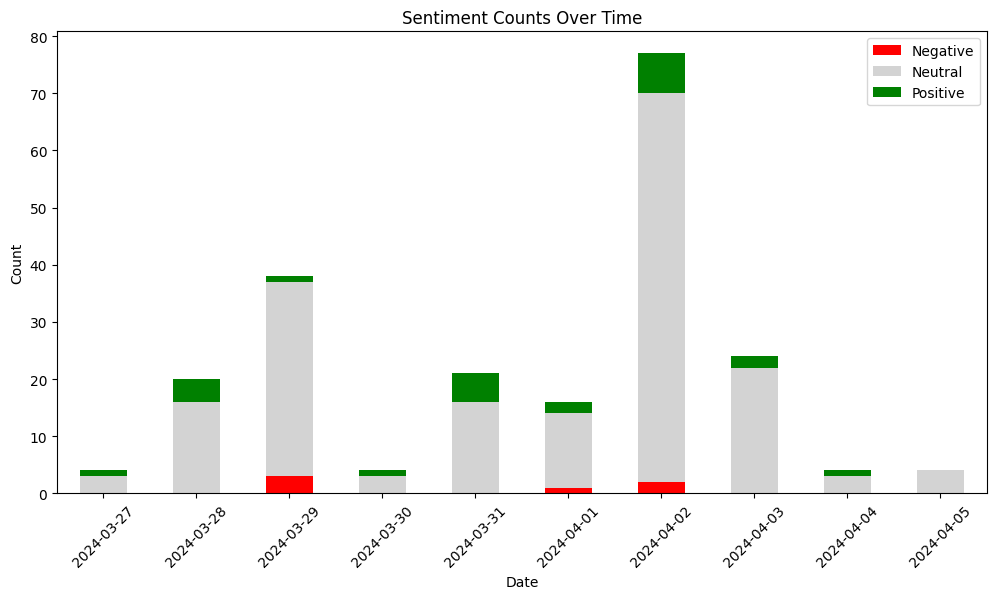

In [41]:
import matplotlib.pyplot as plt

# Group by date and sentiment_label, then count occurrences
grouped = df.groupby(['date', 'sentiment_label']).size().unstack(fill_value=0)

# Plotting
grouped.plot(kind='bar', stacked=True, figsize=(12, 6), color=['red', 'lightgray', 'green'])
plt.title('Sentiment Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(['Negative', 'Neutral', 'Positive'])
plt.xticks(rotation=45)
plt.show()

### Insights from Sentiment Counts Over Time Graph

The graph shows the distribution of sentiments in comments over time, highlighting several key points:

- **Neutral Dominance**: A large number of comments are neutral, suggesting a focus on information sharing.

- **Occasional Positivity**: Peaks in positive sentiment may relate to favorable events or news.

- **Sparse Negativity**: Negative sentiments are few, indicating less adverse sentiment towards `VOO`.

- **Engagement Fluctuations**: The bar heights vary, indicating shifts in community interaction levels, possibly driven by market events.

- **Important Dates to Note**: Dates with high sentiment extremes could align with significant market events and may need further examination.


---

### 2. Heatmap for Sentiment Analysis
#### Heatmap for Sentiment Count
- **What it shows**: This heatmap visualizes the frequency of comments classified as positive, neutral, or negative for each date.
- **Interpretation**:
  - The heatmap's cells represent the number of comments for each sentiment category on specific dates.
  - The intensity of the red color reflects the volume of comments - more intensely red colors indicate a higher number of comments, while cooler blue shades suggest fewer comments.

#### Heatmap for Average Sentiment Intensity
- **What it shows**: It indicates the average sentiment score for comments, reflecting the intensity of sentiment on each date.
- **Interpretation**:
  - Each cell displays the average sentiment score for a given date.
  - The intensity of the color represents the average sentiment strength, with darker colors signifying stronger sentiments.

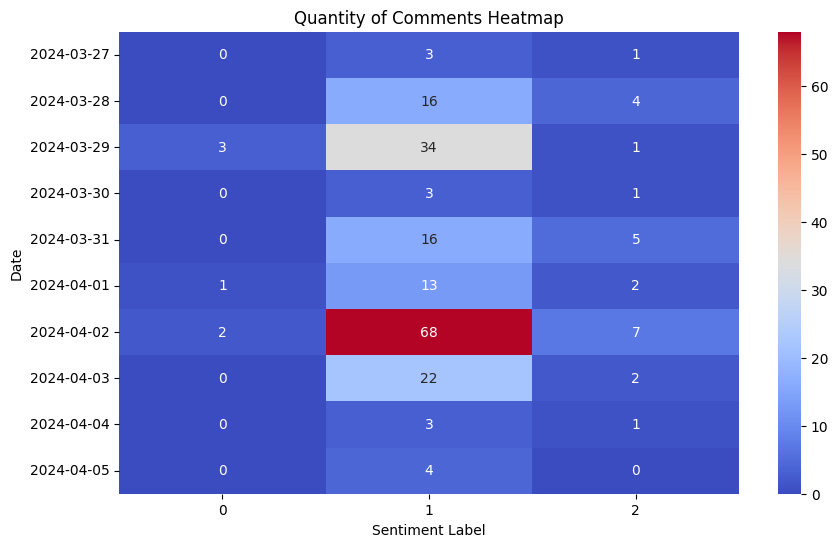

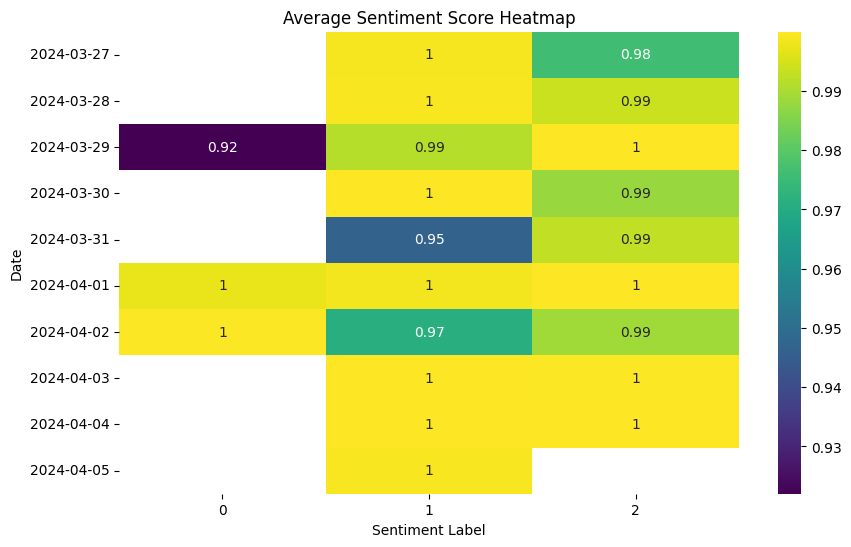

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = {
    'date': df['date'],
    'sentiment_label': df['sentiment_label'],
    'sentiment_score': df['sentiment_score']
}

visualization_df = pd.DataFrame(data)

# Heatmap 1: Quantity of Comments
# Counting comments
count_df = visualization_df.groupby(['date', 'sentiment_label']).size().unstack(fill_value=0)

# Plotting heatmap for quantity
plt.figure(figsize=(10, 6))
sns.heatmap(count_df, annot=True, cmap='coolwarm')
plt.title('Quantity of Comments Heatmap')
plt.xlabel('Sentiment Label')
plt.ylabel('Date')
plt.show()

# Heatmap 2: Average Sentiment Score
# Calculating average sentiment score
# Group by 'date' and 'sentiment_label' and compute average sentiment score
grouped = visualization_df.groupby(['date', 'sentiment_label']).mean().reset_index()

# Pivot the table
pivot_df = grouped.pivot(index='date', columns='sentiment_label', values='sentiment_score')

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap='viridis')
plt.title('Average Sentiment Score Heatmap')
plt.xlabel('Sentiment Label')
plt.ylabel('Date')
plt.show()


### Insights from the Heatmaps

#### Quantity of Comments Heatmap
The 'Quantity of Comments Heatmap' provides a quick visual understanding of the volume of comments over time, categorized by sentiment:

- **Diverse Sentiment Expression**: The heatmap indicates varied sentiment expression across different dates, with a mix of neutral, positive, and occasionally negative comments.
- **Dominant Days**: Certain days show a higher overall number of comments, hinting at increased user activity which could be aligned with market movements or news events.
- **Neutral Commentary**: A consistent presence of neutral comments suggests a steady stream of informational content without strong sentiment bias.

#### Average Sentiment Score Heatmap
The 'Average Sentiment Score Heatmap' offers insights into the intensity of expressed sentiments:

- **Consistent Sentiment Intensity**: There's a general trend of high sentiment scores across the dates, regardless of the sentiment category, indicating strong opinions are being expressed.
- **Neutral Scores**: Neutral comments tend to have slightly lower scores, possibly reflecting a lack of strong sentiment either way.
- **Missing Values Explained**: Not all dates have values for each sentiment label. This absence of data points could be due to several reasons: 
    - less overall activity on the subreddit
    - no events triggering that sentiment
    - lack of engagement from users in expressing that sentiment


---

### 3. Stacked Bar Chart with Sentiment Scores
- **What it shows**: Displays the number of comments broken down by sentiment score ranges, showing the strength of sentiments.
- **Interpretation**: 
    - **Positive Sentiment Score**: Larger segments in the higher score ranges indicate days when positive sentiments were particularly intense, signifying stronger optimism among commenters.
    - **Neutral Sentiment Score**: Larger segments suggest a higher consensus among commenters in their neutral stance.
    - **Negative Sentiment Score**: Larger segments in the lower score bins suggest days marked by more intense negative sentiment, potentially reflecting widespread concerns or adverse reactions to events.

C:\Users\User\AppData\Local\Temp\ipykernel_23516\3641689167.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



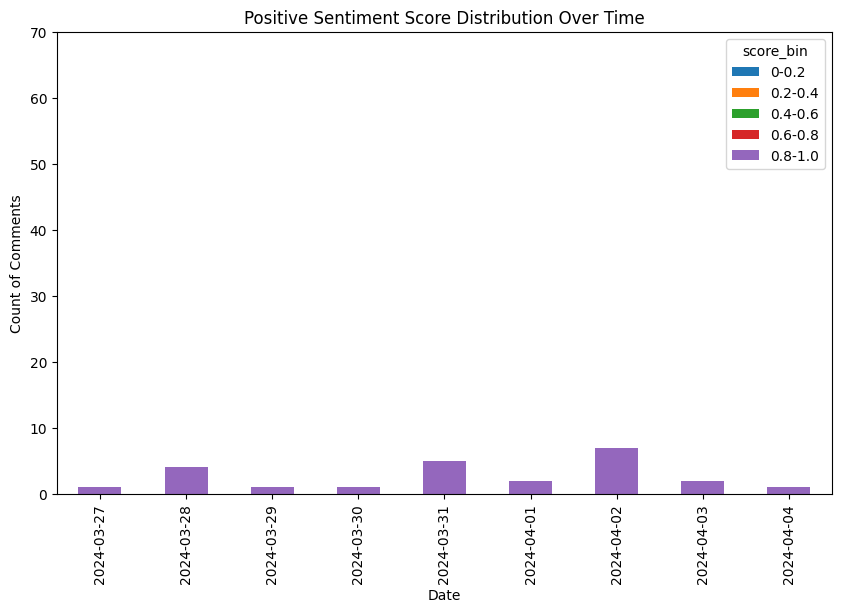

C:\Users\User\AppData\Local\Temp\ipykernel_23516\3641689167.py:31: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



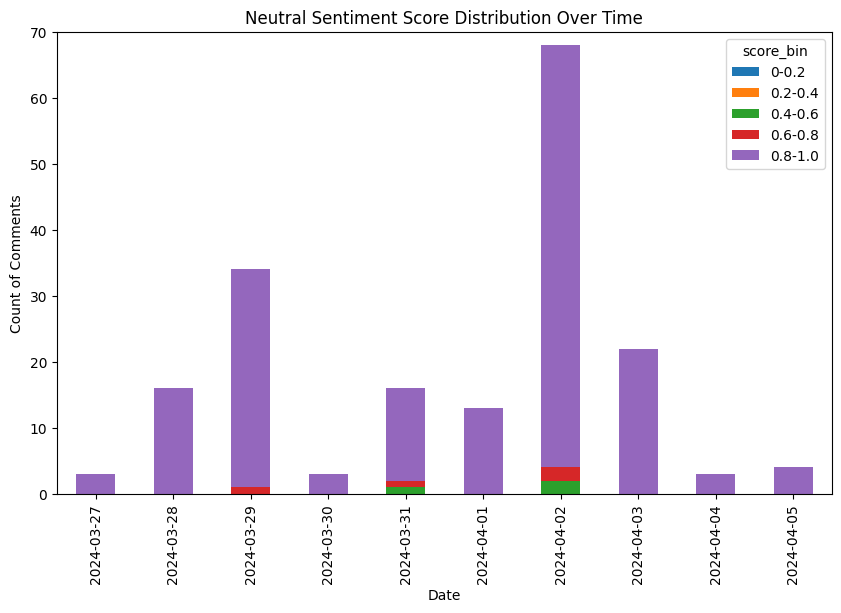

C:\Users\User\AppData\Local\Temp\ipykernel_23516\3641689167.py:40: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



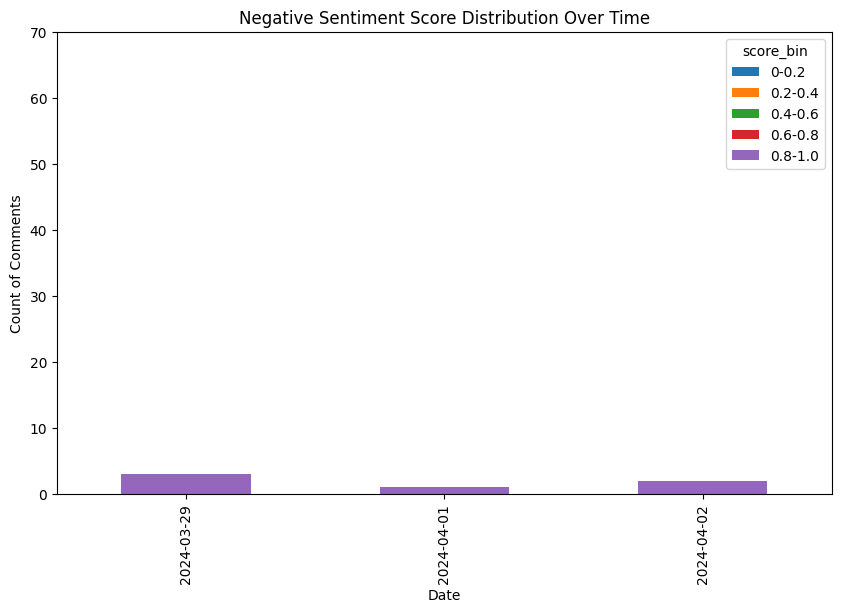

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'date': df['date'],
    'sentiment_score': df['sentiment_score'],
    'sentiment_label': df['sentiment_label']
}
visualization_df = pd.DataFrame(data)

# Bin the sentiment scores
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']
visualization_df['score_bin'] = pd.cut(visualization_df['sentiment_score'], bins=bins, labels=labels)

# Separate Positive, Neutral and Negative DataFrames
positive_df = visualization_df[visualization_df['sentiment_label'] == 2]
neutral_df = visualization_df[visualization_df['sentiment_label'] == 1]
negative_df = visualization_df[visualization_df['sentiment_label'] == 0]

# Plotting Stacked Bar Chart for Positive Sentiments
pivot_positive = positive_df.groupby(['date', 'score_bin']).size().unstack(fill_value=0)
pivot_positive.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Positive Sentiment Score Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Count of Comments')
plt.ylim(0, 70)
plt.show()

# Plotting Stacked Bar Chart for Neutral Sentiments
pivot_neutral = neutral_df.groupby(['date', 'score_bin']).size().unstack(fill_value=0)
pivot_neutral.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Neutral Sentiment Score Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Count of Comments')
plt.ylim(0, 70)
plt.show()

# Plotting Stacked Bar Chart for Negative Sentiments
pivot_negative = negative_df.groupby(['date', 'score_bin']).size().unstack(fill_value=0)
pivot_negative.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Negative Sentiment Score Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Count of Comments')
plt.ylim(0, 70)
plt.show()


### Insights from Stacked Bar Charts of Sentiment Score Distribution

#### Positive Sentiment Score Distribution
- **Observations**: The chart for positive sentiments illustrates minimal instances of highly positive comments (score range 0.8-1.0) across the observed dates.
- **Inference**: This trend indicates that while there are instances of positive discourse regarding VOO, the sentiment tends to be moderate, suggesting a cautious optimism among commenters.

#### Neutral Sentiment Score Distribution
- **Observations**: The neutral sentiment chart shows a significant clustering of comments within a mid-range of sentiment scores, with a noticeable spike on a particular date.
- **Inference**: This spike may pinpoint a day where an event or announcement led to increased discussion that was predominantly informational or speculative in nature, lacking a clear positive or negative sentiment.

#### Negative Sentiment Score Distribution
- **Observations**: Negative sentiment distribution is sparse and consistent, with a negligible presence of deeply negative sentiments.
- **Inference**: The general absence of strong negative sentiments suggests a predominantly neutral or positive perception of VOO within the community, possibly indicating no major adverse events that might impact sentiment negatively.


---

### 4. Normalized Cumulative Sentiment Score Over Time
- **What it shows**: The plot potentially illustrates separate cumulative lines for each sentiment label (positive, neutral, negative), showing how each sentiment score accumulates over time.
- **Interpretation**:
    - An ascending line suggests a relative increase in the cumulative intensity for that sentiment compared to its previous state.
    - A steeper incline indicates a more rapid accumulation of sentiment, highlighting days with particularly strong sentiment expression.

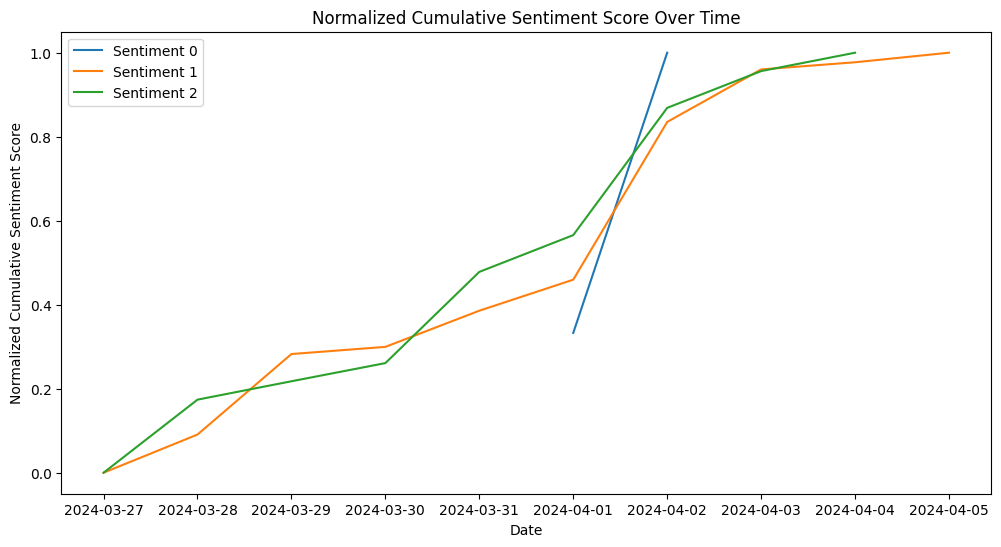

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'date' and 'sentiment_label', then calculate the cumulative sum
grouped = df.groupby(['date', 'sentiment_label'])['sentiment_score'].sum().groupby(level=1).cumsum().reset_index()

# Pivot the table
pivot_df = grouped.pivot(index='date', columns='sentiment_label', values='sentiment_score')

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_scores = scaler.fit_transform(pivot_df)
scaled_scores_df = pd.DataFrame(scaled_scores, columns=pivot_df.columns, index=pivot_df.index)

# Now plot the scaled scores
plt.figure(figsize=(12, 6))
for sentiment_label in scaled_scores_df.columns:
    plt.plot(scaled_scores_df.index, scaled_scores_df[sentiment_label], label=f'Sentiment {sentiment_label}')

plt.xlabel('Date')
plt.ylabel('Normalized Cumulative Sentiment Score')
plt.title('Normalized Cumulative Sentiment Score Over Time')
plt.legend()
plt.show()


### Observations from Normalized Cumulative Sentiment Score Graph

- Initially, there is a **steady rise** in all sentiment labels, suggesting a uniform accumulation of sentiments.
- Sentiment 2 (Positive) experiences **sharp increases**, indicating bursts of strong positive sentiment.
- Towards the end of the timeline, Sentiment 0 (Negative) and Sentiment 2 (Positive) **converge**, implying that positive and negative sentiments are expressed with similar intensity.
- **Fluctuations and shifts** in the sentiment lines suggest varying community sentiment over time.
- The **steady climb** of Sentiment 1 (Neutral) could indicate a consistent level of informational or neutral commentary.

### Insights from Normalized Cumulative Sentiment Score Graph

- The convergence of sentiment lines may indicate **polarized views** within the community, with strong opinions on both sides.
- Dates with significant changes in sentiment lines can pinpoint when key **events or news** influenced public opinion.
- The **normalization of scores** makes it easier to observe relative changes over time, rather than absolute sentiment values.
- Identifying **trends** in sentiment can be useful for correlating public perception with **market movements** or significant **external events**.
- Strategic analysis could leverage these insights to better understand the **impact of sentiment on investment decisions**.


---

### 5. Rate of Change in Sentiment Scores Over Time

- **What it shows**: This analysis focuses on the velocity of sentiment shifts among the comments, capturing a dynamic picture of public opinion over time.
- **Interpretation**: 
    - By calculating the first derivative of cumulative sentiment scores, we identify how rapidly the sentiments are rising or falling.
    - A **rising line** suggests growing sentiment intensity, possibly in reaction to specific news or events.
    - A **declining line** indicates decreasing sentiment intensity, which may occur as a topic becomes less relevant or after the peak of an event.


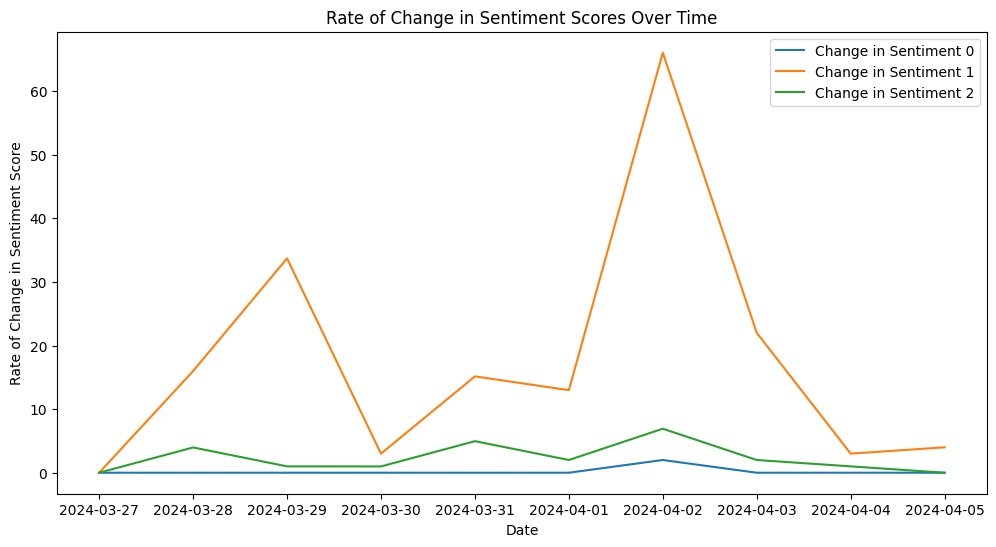

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'date' and 'sentiment_label', then calculate the cumulative sum
grouped = df.groupby(['date', 'sentiment_label'])['sentiment_score'].sum().groupby(level=1).cumsum().reset_index()

# Pivot the table
pivot_df = grouped.pivot(index='date', columns='sentiment_label', values='sentiment_score')

change_in_scores = pivot_df.diff().fillna(0)  # Calculate the change from previous time point

# Plot the rate of change
plt.figure(figsize=(12, 6))
for sentiment_label in change_in_scores.columns:
    plt.plot(change_in_scores.index, change_in_scores[sentiment_label], label=f'Change in Sentiment {sentiment_label}')

plt.xlabel('Date')
plt.ylabel('Rate of Change in Sentiment Score')
plt.title('Rate of Change in Sentiment Scores Over Time')
plt.legend()
plt.show()


### Observations from the Rate of Change in Sentiment Scores Over Time Graph

- **Sentiment 0 (Negative)**: Indicated by the blue line, remains consistently low throughout the period.
- **Sentiment 1 (Neutral)**: Indicated by the orange line, exhibits the most considerable volatility, with sharp increases and decreases.
- **Sentiment 2 (Positive)**: Indicated by the green line, exhibits noticeable volatility with a sharp peak and subsequent drop.

### Insights from the Rate of Change in Sentiment Scores Over Time Graph

- The consistent low level of change in negative sentiment could imply that negative opinions on `VOO` are stable, with no significant events stirring up negativity during the observed period.
- The peak in neutral sentiment might be associated with an occurrence that sparked discussion without necessarily swaying public opinion positively or negatively.
- The volatility in positive sentiment points to specific dates where positive sentiments were strongly influenced, warranting further exploration to understand what caused these shifts.

---

## Analyzing the Overall Sentiment

### 1. Net Sentiment Score (NSS)

The **Normalized Sentiment Score (NSS)** is a statistical method used to quantify the overall sentiment of a dataset. The NSS is derived by subtracting the cumulative sentiment scores of negative comments from those of positive comments for each date. Neutral comments are not included in the NSS calculation as they are considered to have no impact on the overall sentiment polarity. The `MinMaxScaler` from scikit-learn normalizes NSS values to a 0-1 scale, enhancing comparative analysis and visualization by aligning all scores between the observed minimum and maximum.

In [46]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

data = {
    'date': df['date'],
    'sentiment_label': df['sentiment_label'],
    'sentiment_score': df['sentiment_score']
}
nss_df = pd.DataFrame(data)

# Calculate Net Sentiment Score including positive, neutral, and negative sentiments
nss = nss_df.groupby('date').apply(
    lambda x: x[x['sentiment_label'] == 2]['sentiment_score'].sum()  # Sum of positive scores
             - x[x['sentiment_label'] == 0]['sentiment_score'].sum()  # Subtract sum of negative scores
)

# Convert to DataFrame and reset index
nss_df = nss.reset_index()
nss_df.columns = ['date', 'nss']  # Renaming columns

# Normalize the NSS to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
nss_df['normalized_nss'] = scaler.fit_transform(nss_df['nss'].values.reshape(-1, 1))

# Display the DataFrame
nss_df


C:\Users\User\AppData\Local\Temp\ipykernel_23516\4173628570.py:12: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,date,nss,normalized_nss
0,2024-03-27,0.976062,0.407557
1,2024-03-28,3.974690,0.853237
2,2024-03-29,-1.766060,0.000000
3,2024-03-30,0.987844,0.409308
4,2024-03-31,4.962137,1.000000
5,2024-04-01,1.002523,0.411490
6,2024-04-02,4.922970,0.994179
7,2024-04-03,1.999133,0.559614
8,2024-04-04,0.999972,0.411110
9,2024-04-05,0.000000,0.262486


In [47]:
voo_df = pd.read_csv('../datasets/VOO_sentiment.csv')
voo_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-03-26,479.059998,479.369995,476.429993,476.600006,476.600006,8073500
1,2024-03-27,479.510010,480.869995,477.450012,480.760010,480.760010,4951400
2,2024-03-28,480.869995,482.160004,480.500000,480.700012,480.700012,4065000
3,2024-04-01,481.440002,481.959991,478.829987,480.070007,480.070007,5734000
4,2024-04-02,476.329987,476.989990,474.709991,476.929993,476.929993,4817800


In [48]:
voo_df['actual_label'] = (voo_df['Close'] > voo_df['Open']).astype(int)

voo_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,actual_label
0,2024-03-26,479.059998,479.369995,476.429993,476.600006,476.600006,8073500,0
1,2024-03-27,479.510010,480.869995,477.450012,480.760010,480.760010,4951400,1
2,2024-03-28,480.869995,482.160004,480.500000,480.700012,480.700012,4065000,0
3,2024-04-01,481.440002,481.959991,478.829987,480.070007,480.070007,5734000,0
4,2024-04-02,476.329987,476.989990,474.709991,476.929993,476.929993,4817800,1


In [49]:
nss_df['date'] = pd.to_datetime(nss_df['date'])
voo_df['Date'] = pd.to_datetime(voo_df['Date'])

voo_df['actual_label'] = voo_df['actual_label']

nss_df = pd.merge(nss_df, voo_df, how='left', left_on='date', right_on='Date')

nss_df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

nss_df

,date,nss,normalized_nss,actual_label
0,2024-03-27,0.976062,0.407557,1.0
1,2024-03-28,3.974690,0.853237,0.0
2,2024-03-29,-1.766060,0.000000,NaN
3,2024-03-30,0.987844,0.409308,NaN
4,2024-03-31,4.962137,1.000000,NaN
5,2024-04-01,1.002523,0.411490,0.0
6,2024-04-02,4.922970,0.994179,1.0
7,2024-04-03,1.999133,0.559614,1.0
8,2024-04-04,0.999972,0.411110,0.0
9,2024-04-05,0.000000,0.262486,1.0


1 means that stock price go higher, 0 means that stock price go lower, NaN means non-trading days.

### Correlation Analysis and Statistical Measures

In [50]:
# Calculate correlation for NSS
correlation_nss = nss_df['normalized_nss'].corr(nss_df['actual_label'], method='pearson')
print("Pearson Correlation Coefficient (NSS):", correlation_nss)

Pearson Correlation Coefficient (NSS): -0.005295778542009397


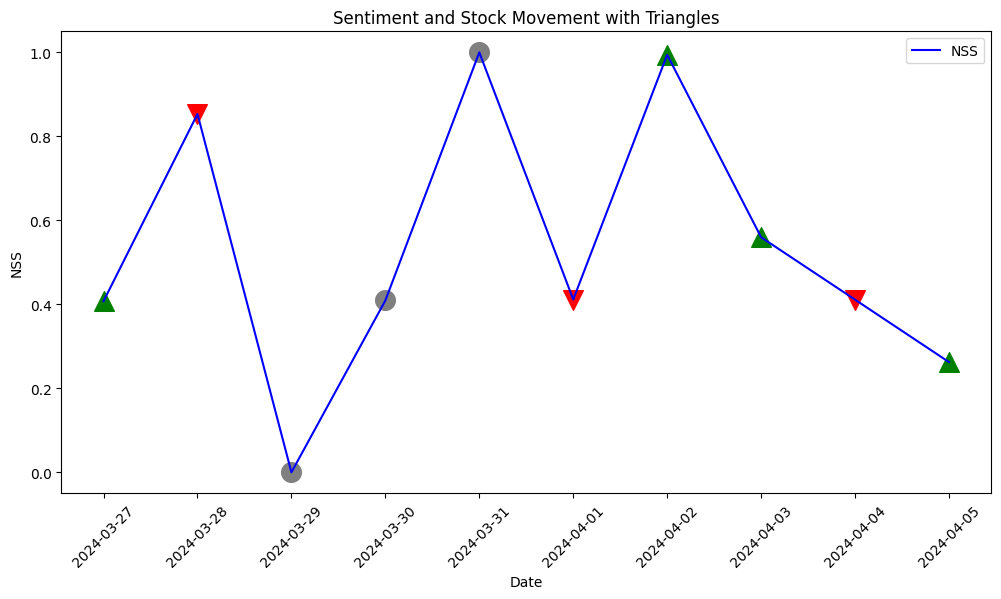

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(nss_df['date'], nss_df['normalized_nss'], label='NSS', color='blue')

for i, row in nss_df.iterrows():
    if row['actual_label'] == 1:
        plt.scatter(row['date'], row['normalized_nss'], color='green', marker='^', s=200)
    elif row['actual_label'] == 0:
        plt.scatter(row['date'], row['normalized_nss'], color='red', marker='v', s=200)
    else:
        plt.scatter(row['date'], row['normalized_nss'], color='grey', marker='o', s=200)

plt.xlabel('Date')
plt.ylabel('NSS')
plt.title('Sentiment and Stock Movement with Triangles')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [52]:
import plotly.graph_objects as go

# Creating the line plot for weighted average sentiment
fig = go.Figure()
fig.add_trace(go.Scatter(x=nss_df['date'], y=nss_df['normalized_nss'], mode='lines', name='NSS Sentiment', line=dict(color='blue')))

# Adding markers for actual stock labels
for i, row in nss_df.iterrows():
    if row['actual_label'] == 1:
        fig.add_trace(go.Scatter(x=[row['date']], y=[row['normalized_nss']], mode='markers', marker_symbol='triangle-up', marker_color='green', marker_size=10, name='Stock Up'))
    elif row['actual_label'] == 0:
        fig.add_trace(go.Scatter(x=[row['date']], y=[row['normalized_nss']], mode='markers', marker_symbol='triangle-down', marker_color='red', marker_size=10, name='Stock Down'))
    else:
        fig.add_trace(go.Scatter(x=[row['date']], y=[row['normalized_nss']], mode='markers', marker_symbol='circle', marker_color='grey', marker_size=10, name='Market Closed'))

# Setting layout for the figure
fig.update_layout(title='Sentiment and Stock Movement with Interactive Triangles', xaxis_title='Date', yaxis_title='NSS Sentiment', legend_title='Legend')
fig.show()

### Correlation between Stock Daily Return and NSS Sentiment

In [53]:
voo_df = pd.read_csv('../datasets/VOO_sentiment.csv')
voo_df['daily_return'] = (voo_df['Close'] - voo_df['Open']) / voo_df['Open']

voo_df

,Date,Open,High,Low,Close,Adj Close,Volume,daily_return
0,2024-03-26,479.059998,479.369995,476.429993,476.600006,476.600006,8073500,-0.005135
1,2024-03-27,479.510010,480.869995,477.450012,480.760010,480.760010,4951400,0.002607
2,2024-03-28,480.869995,482.160004,480.500000,480.700012,480.700012,4065000,-0.000353
3,2024-04-01,481.440002,481.959991,478.829987,480.070007,480.070007,5734000,-0.002846
4,2024-04-02,476.329987,476.989990,474.709991,476.929993,476.929993,4817800,0.001260
5,2024-04-03,475.839996,478.799988,475.790009,477.359985,477.359985,6218200,0.003194
6,2024-04-04,481.200012,481.480011,471.269989,471.480011,471.480011,6871200,-0.020200
7,2024-04-05,472.850006,478.329987,472.420013,476.489990,476.489990,5582200,0.007698


In [54]:
voo_df['Date'] = pd.to_datetime(voo_df['Date'])
nss_df['date'] = pd.to_datetime(nss_df['date'])

nss_df = pd.merge(nss_df, voo_df, how='left', left_on='date', right_on='Date')
nss_df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

nss_df

,date,nss,normalized_nss,actual_label,daily_return
0,2024-03-27,0.976062,0.407557,1.0,0.002607
1,2024-03-28,3.974690,0.853237,0.0,-0.000353
2,2024-03-29,-1.766060,0.000000,NaN,NaN
3,2024-03-30,0.987844,0.409308,NaN,NaN
4,2024-03-31,4.962137,1.000000,NaN,NaN
5,2024-04-01,1.002523,0.411490,0.0,-0.002846
6,2024-04-02,4.922970,0.994179,1.0,0.001260
7,2024-04-03,1.999133,0.559614,1.0,0.003194
8,2024-04-04,0.999972,0.411110,0.0,-0.020200
9,2024-04-05,0.000000,0.262486,1.0,0.007698


#### Dual Y-Axis Time-Series Plot for Normalized NSS and Daily Stock Returns

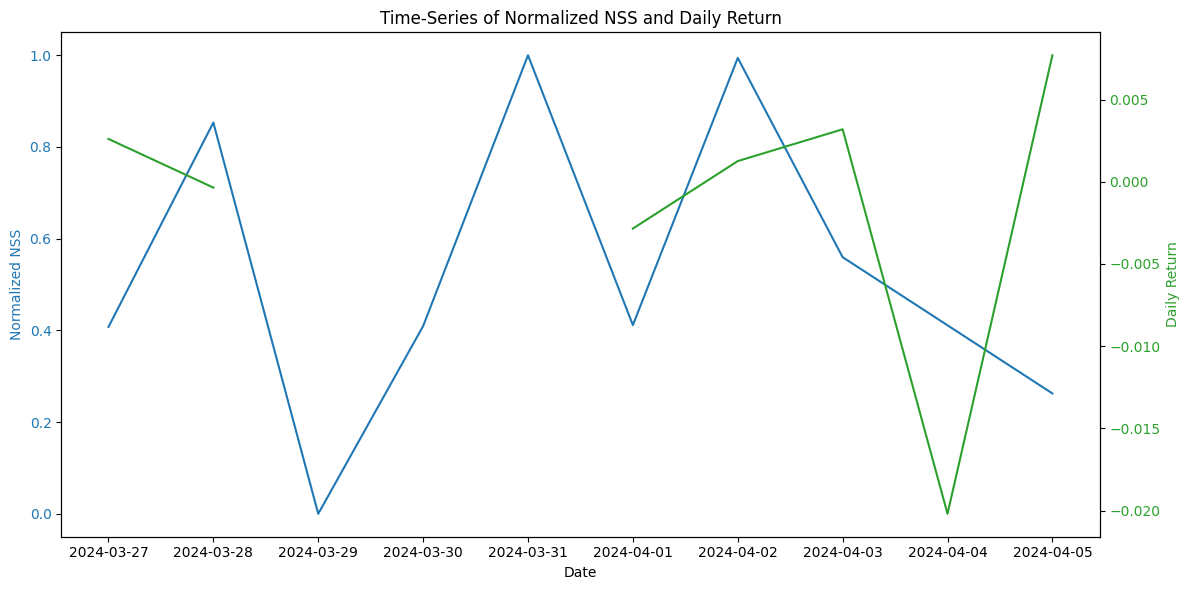

In [55]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# First axis (ax1) for NSS
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized NSS', color=color)
ax1.plot(nss_df['date'], nss_df['normalized_nss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis (ax2) for Daily Return
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Daily Return', color=color)
ax2.plot(nss_df['date'], nss_df['daily_return'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show plot
plt.title('Time-Series of Normalized NSS and Daily Return')
fig.tight_layout()  # otherwise the right y-label may be slightly clipped
plt.show()


### 2. Weighted Average Calculation

In [56]:
import pandas as pd

data = {
    'date': df['date'],
    'sentiment_label': df['sentiment_label'],
    'sentiment_score': df['sentiment_score']
}
weighted_avg_df = pd.DataFrame(data)

# Calculate Weighted Average Sentiment
weighted_avg = weighted_avg_df.groupby('date').apply(
    lambda x: (x['sentiment_label'] * x['sentiment_score']).sum() / x['sentiment_score'].sum())

# Convert to DataFrame and reset index
weighted_avg_df = weighted_avg.reset_index()
weighted_avg_df.columns = ['date', 'weighted_average']  # Renaming columns

weighted_avg_df


C:\Users\User\AppData\Local\Temp\ipykernel_23516\3680299673.py:11: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,date,weighted_average
0,2024-03-27,1.245679
1,2024-03-28,1.199104
2,2024-03-29,0.952866
3,2024-03-30,1.247756
4,2024-03-31,1.246772
5,2024-04-01,1.062737
6,2024-04-02,1.065669
7,2024-04-03,1.083322
8,2024-04-04,1.250019
9,2024-04-05,1.000000


In [57]:
voo_df = pd.read_csv('../datasets/VOO_sentiment.csv')
voo_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-03-26,479.059998,479.369995,476.429993,476.600006,476.600006,8073500
1,2024-03-27,479.510010,480.869995,477.450012,480.760010,480.760010,4951400
2,2024-03-28,480.869995,482.160004,480.500000,480.700012,480.700012,4065000
3,2024-04-01,481.440002,481.959991,478.829987,480.070007,480.070007,5734000
4,2024-04-02,476.329987,476.989990,474.709991,476.929993,476.929993,4817800
5,2024-04-03,475.839996,478.799988,475.790009,477.359985,477.359985,6218200
6,2024-04-04,481.200012,481.480011,471.269989,471.480011,471.480011,6871200
7,2024-04-05,472.850006,478.329987,472.420013,476.489990,476.489990,5582200


In [58]:
voo_df['actual_label'] = (voo_df['Close'] > voo_df['Open']).astype(int)

voo_df

,Date,Open,High,Low,Close,Adj Close,Volume,actual_label
0,2024-03-26,479.059998,479.369995,476.429993,476.600006,476.600006,8073500,0
1,2024-03-27,479.510010,480.869995,477.450012,480.760010,480.760010,4951400,1
2,2024-03-28,480.869995,482.160004,480.500000,480.700012,480.700012,4065000,0
3,2024-04-01,481.440002,481.959991,478.829987,480.070007,480.070007,5734000,0
4,2024-04-02,476.329987,476.989990,474.709991,476.929993,476.929993,4817800,1
5,2024-04-03,475.839996,478.799988,475.790009,477.359985,477.359985,6218200,1
6,2024-04-04,481.200012,481.480011,471.269989,471.480011,471.480011,6871200,0
7,2024-04-05,472.850006,478.329987,472.420013,476.489990,476.489990,5582200,1


In [59]:
weighted_avg_df['date'] = pd.to_datetime(weighted_avg_df['date'])
voo_df['Date'] = pd.to_datetime(voo_df['Date'])

weighted_avg_df = pd.merge(weighted_avg_df, voo_df, how='left', left_on='date', right_on='Date')

weighted_avg_df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

weighted_avg_df

,date,weighted_average,actual_label
0,2024-03-27,1.245679,1.0
1,2024-03-28,1.199104,0.0
2,2024-03-29,0.952866,NaN
3,2024-03-30,1.247756,NaN
4,2024-03-31,1.246772,NaN
5,2024-04-01,1.062737,0.0
6,2024-04-02,1.065669,1.0
7,2024-04-03,1.083322,1.0
8,2024-04-04,1.250019,0.0
9,2024-04-05,1.000000,1.0


1 means that stock price go higher, 0 means that stock price go lower, NaN means non-trading days.

### Correlation Analysis and Statistical Measures

In [60]:
import pandas as pd

correlation = weighted_avg_df['weighted_average'].corr(weighted_avg_df['actual_label'], method='pearson')
print("Pearson Correlation Coefficient:", correlation)

Pearson Correlation Coefficient: -0.38363834138989156


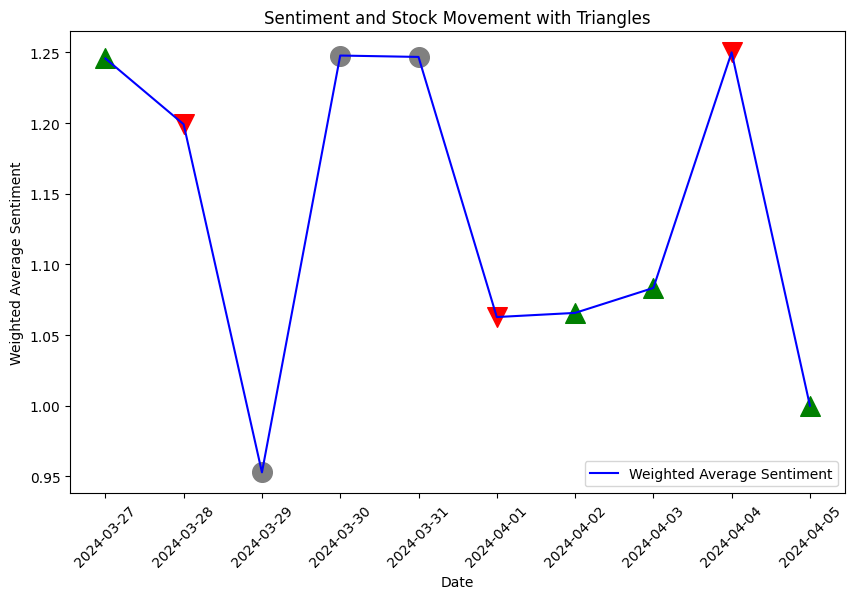

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(weighted_avg_df['date'], weighted_avg_df['weighted_average'], label='Weighted Average Sentiment', color='blue')

for i, row in weighted_avg_df.iterrows():
    if row['actual_label'] == 1:
        plt.scatter(row['date'], row['weighted_average'], color='green', marker='^', s=200)
    elif row['actual_label'] == 0:
        plt.scatter(row['date'], row['weighted_average'], color='red', marker='v', s=200)
    else:
        plt.scatter(row['date'], row['weighted_average'], color='grey', marker='o', s=200)

plt.xlabel('Date')
plt.ylabel('Weighted Average Sentiment')
plt.title('Sentiment and Stock Movement with Triangles')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [62]:
import plotly.graph_objects as go

# Creating the line plot for weighted average sentiment
fig = go.Figure()
fig.add_trace(go.Scatter(x=weighted_avg_df['date'], y=weighted_avg_df['weighted_average'], mode='lines', name='Weighted Average Sentiment', line=dict(color='blue')))

# Adding markers for actual stock labels
for i, row in weighted_avg_df.iterrows():
    if row['actual_label'] == 1:
        fig.add_trace(go.Scatter(x=[row['date']], y=[row['weighted_average']], mode='markers', marker_symbol='triangle-up', marker_color='green', marker_size=10, name='Stock Up'))
    elif row['actual_label'] == 0:
        fig.add_trace(go.Scatter(x=[row['date']], y=[row['weighted_average']], mode='markers', marker_symbol='triangle-down', marker_color='red', marker_size=10, name='Stock Down'))
    else:
        fig.add_trace(go.Scatter(x=[row['date']], y=[row['weighted_average']], mode='markers', marker_symbol='circle', marker_color='grey', marker_size=10, name='Market Closed'))

# Setting layout for the figure
fig.update_layout(title='Sentiment and Stock Movement with Interactive Triangles', xaxis_title='Date', yaxis_title='Weighted Average Sentiment', legend_title='Legend')
fig.show()


### Correlation between Stock Daily Returns and Weighted Average Sentiment

In [63]:
voo_df = pd.read_csv('../datasets/VOO_sentiment.csv')
voo_df['daily_return'] = (voo_df['Close'] - voo_df['Open']) / voo_df['Open']

voo_df

,Date,Open,High,Low,Close,Adj Close,Volume,daily_return
0,2024-03-26,479.059998,479.369995,476.429993,476.600006,476.600006,8073500,-0.005135
1,2024-03-27,479.510010,480.869995,477.450012,480.760010,480.760010,4951400,0.002607
2,2024-03-28,480.869995,482.160004,480.500000,480.700012,480.700012,4065000,-0.000353
3,2024-04-01,481.440002,481.959991,478.829987,480.070007,480.070007,5734000,-0.002846
4,2024-04-02,476.329987,476.989990,474.709991,476.929993,476.929993,4817800,0.001260
5,2024-04-03,475.839996,478.799988,475.790009,477.359985,477.359985,6218200,0.003194
6,2024-04-04,481.200012,481.480011,471.269989,471.480011,471.480011,6871200,-0.020200
7,2024-04-05,472.850006,478.329987,472.420013,476.489990,476.489990,5582200,0.007698


In [64]:
voo_df['Date'] = pd.to_datetime(voo_df['Date'])
weighted_avg_df['date'] = pd.to_datetime(weighted_avg_df['date'])

weighted_avg_df = pd.merge(weighted_avg_df, voo_df, how='left', left_on='date', right_on='Date')
weighted_avg_df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

weighted_avg_df

,date,weighted_average,actual_label,daily_return
0,2024-03-27,1.245679,1.0,0.002607
1,2024-03-28,1.199104,0.0,-0.000353
2,2024-03-29,0.952866,NaN,NaN
3,2024-03-30,1.247756,NaN,NaN
4,2024-03-31,1.246772,NaN,NaN
5,2024-04-01,1.062737,0.0,-0.002846
6,2024-04-02,1.065669,1.0,0.001260
7,2024-04-03,1.083322,1.0,0.003194
8,2024-04-04,1.250019,0.0,-0.020200
9,2024-04-05,1.000000,1.0,0.007698


#### Dual Y-Axis Time-Series Plot for Weighted Average and Daily Stock Returns

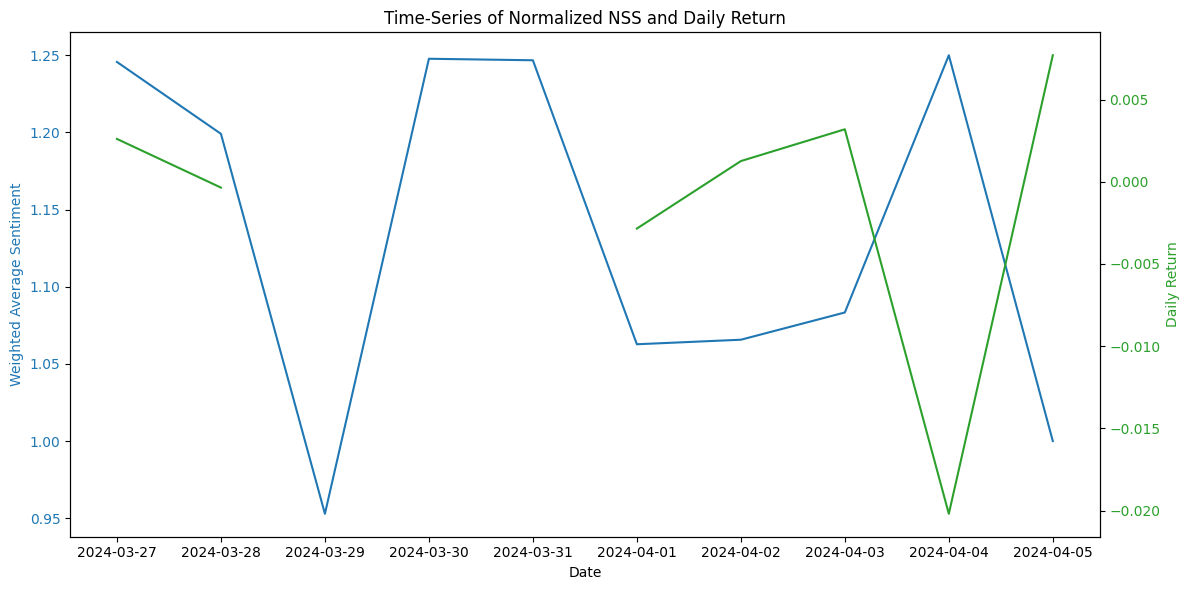

In [65]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# First axis (ax1) for NSS
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Weighted Average Sentiment', color=color)
ax1.plot(nss_df['date'], weighted_avg_df['weighted_average'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis (ax2) for Daily Return
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Daily Return', color=color)
ax2.plot(nss_df['date'], weighted_avg_df['daily_return'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show plot
plt.title('Time-Series of Normalized NSS and Daily Return')
fig.tight_layout()  # otherwise the right y-label may be slightly clipped
plt.show()
